# GPS Location Analysis

This notebook analyzes GPS location data to infer significant locations in a subject's life. It was developed as part of a CS4501 Data Privacy project at UVA.

Use the detailed README to process your own data.

### Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from collections import Counter
import seaborn as sns
from geopy.distance import great_circle

# Define the path to the GPS data folder
gps_folder = "gps/"

# Function to load a GPS file with proper handling of the specific format
def load_gps_file(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        data = []
        
        for line in lines:
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # If line contains a comma, it's likely a normal CSV format
            if ',' in line:
                parts = line.strip().split(',')
                
                # Skip header line if it contains field names like "time,provider,..."
                if parts[0] == "time" and "provider" in parts:
                    continue
                
                # Process CSV row with proper handling of missing fields
                record = {}
                
                # Ensure the line has the minimum required fields before processing
                if len(parts) >= 6:  # At least time, provider, network_type, accuracy, lat, lon
                    field_names = ['time', 'provider', 'network_type', 'accuracy', 'latitude', 
                                  'longitude', 'altitude', 'bearing', 'speed', 'travelstate']
                    
                    # Handle each column, allowing for missing values
                    for i, field in enumerate(field_names):
                        if i < len(parts) and parts[i].strip():
                            record[field] = parts[i].strip()
                        else:
                            record[field] = np.nan
                    
                    data.append(record)
            
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Convert columns to appropriate data types
        numeric_cols = ['time', 'accuracy', 'latitude', 'longitude', 'altitude', 'bearing', 'speed']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Convert Unix timestamp to datetime
        if 'time' in df.columns:
            df['datetime'] = pd.to_datetime(df['time'], unit='s')
        
        # Format the display options to avoid scientific notation
        pd.set_option('display.float_format', '{:.6f}'.format)
        
        return df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Get a list of all GPS files
gps_files = glob.glob(gps_folder + "gps_u*.csv")

# Print the number of files found
print(f"Found {len(gps_files)} GPS files")

# Load a sample file to check structure
if gps_files:
    sample_file = gps_files[0]
    print(f"Loading sample file: {sample_file}")
    sample_data = load_gps_file(sample_file)
    
    if sample_data is not None:
        print(f"Sample file has {len(sample_data)} records")
        print("\nSample data:")
        print(sample_data.head())
        
        # Basic statistics
        print("\nBasic statistics for numeric columns:")
        print(sample_data.describe())
        
        # Check for missing values
        print("\nMissing values:")
        print(sample_data.isnull().sum())
    else:
        print("Failed to load sample file.")
else:
    print("No GPS files found in the specified folder.")

Found 49 GPS files
Loading sample file: gps/gps_u45.csv
Sample file has 2303 records

Sample data:
         time provider network_type  accuracy  latitude  longitude   altitude  \
0  1364410654  network         wifi 22.094000 43.706605 -72.287042   0.000000   
1  1364411866  network         wifi 24.652000 43.706598 -72.287005   0.000000   
2  1364852743  network         wifi 24.060000 43.706614 -72.287039   0.000000   
3  1364853942  network         wifi 25.242000 43.706603 -72.287025   0.000000   
4  1364854001      gps          NaN 14.000000 43.707150 -72.286592 199.399994   

   bearing    speed travelstate            datetime  
0 0.000000 0.000000         NaN 2013-03-27 18:57:34  
1 0.000000 0.000000         NaN 2013-03-27 19:17:46  
2 0.000000 0.000000         NaN 2013-04-01 21:45:43  
3 0.000000 0.000000         NaN 2013-04-01 22:05:42  
4 0.000000 0.559017         NaN 2013-04-01 22:06:41  

Basic statistics for numeric columns:
                   time    accuracy    latitude   l

### Selecting the Best Users for Analysis

In [2]:
def evaluate_user_data(file_path):
    """
    Evaluate a user's GPS data for quality and coverage.
    Returns metrics useful for determining which users have the best data.
    """
    df = load_gps_file(file_path)
    if df is None or len(df) < 10:  # Minimum threshold
        return None
    
    # Calculate metrics
    metrics = {
        'user_id': os.path.basename(file_path).replace('gps_u', '').replace('.csv', ''),
        'record_count': len(df),
        'date_range_days': (df['datetime'].max() - df['datetime'].min()).total_seconds() / (60*60*24),
        'distinct_locations': len(df.groupby(['latitude', 'longitude'])),
    }
    
    # Handle potentially missing travelstate column
    if 'travelstate' in df.columns:
        metrics['stationary_points'] = df[df['travelstate'] == 'stationary'].shape[0]
        metrics['moving_points'] = df[df['travelstate'] == 'moving'].shape[0]
    else:
        metrics['stationary_points'] = 0
        metrics['moving_points'] = 0
    
    # Calculate variance in coordinates to identify users with more movement
    metrics['lat_variance'] = df['latitude'].var()
    metrics['lon_variance'] = df['longitude'].var()
    
    # Calculate average time gaps between points (helps identify consistent data)
    df = df.sort_values('time')
    df['time_diff'] = df['time'].diff()
    metrics['avg_time_gap'] = df['time_diff'].mean()
    metrics['max_time_gap'] = df['time_diff'].max()
    
    return metrics

# Evaluate all users
user_metrics = []
for file in gps_files:
    print(f"Evaluating {file}...")
    metrics = evaluate_user_data(file)
    if metrics:
        user_metrics.append(metrics)

if user_metrics:
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(user_metrics)
    
    # Create a combined score for ranking users
    # We want users with:
    # 1. High record count
    # 2. Longer date range 
    # 3. Good number of distinct locations
    # 4. Mix of stationary and moving points
    # 5. Reasonable variance in coordinates
    
    # Normalize each metric to 0-1 scale
    for col in ['record_count', 'date_range_days', 'distinct_locations', 
                'stationary_points', 'moving_points', 'lat_variance', 'lon_variance']:
        if col in metrics_df.columns and metrics_df[col].max() > 0:
            metrics_df[f'{col}_norm'] = metrics_df[col] / metrics_df[col].max()
        else:
            metrics_df[f'{col}_norm'] = 0
    
    # Calculate a combined score (adjust weights as needed)
    metrics_df['score'] = (
        metrics_df['record_count_norm'] * 0.3 +
        metrics_df['date_range_days_norm'] * 0.2 +
        metrics_df['distinct_locations_norm'] * 0.2 +
        (metrics_df['stationary_points_norm'] + metrics_df['moving_points_norm']) * 0.15 +
        (metrics_df['lat_variance_norm'] + metrics_df['lon_variance_norm']) * 0.15
    )
    
    # Display top users sorted by score
    top_users = metrics_df.sort_values('score', ascending=False).head(10)
    print("\nTop 10 users by overall data quality:")
    print(top_users[['user_id', 'record_count', 'date_range_days', 'distinct_locations', 'score']])
    
    # Select the top 2 users
    best_users = top_users.head(2)['user_id'].values
    print(f"\nBest users selected for analysis: {best_users}")
else:
    print("No valid user data found for evaluation.")
    best_users = []

Evaluating gps/gps_u45.csv...
Evaluating gps/gps_u51.csv...
Evaluating gps/gps_u50.csv...
Evaluating gps/gps_u44.csv...
Evaluating gps/gps_u52.csv...
Evaluating gps/gps_u46.csv...
Evaluating gps/gps_u47.csv...
Evaluating gps/gps_u53.csv...
Evaluating gps/gps_u57.csv...
Evaluating gps/gps_u43.csv...
Evaluating gps/gps_u42.csv...
Evaluating gps/gps_u56.csv...
Evaluating gps/gps_u54.csv...
Evaluating gps/gps_u41.csv...
Evaluating gps/gps_u32.csv...
Evaluating gps/gps_u33.csv...
Evaluating gps/gps_u27.csv...
Evaluating gps/gps_u31.csv...
Evaluating gps/gps_u25.csv...
Evaluating gps/gps_u19.csv...
Evaluating gps/gps_u18.csv...
Evaluating gps/gps_u24.csv...
Evaluating gps/gps_u30.csv...
Evaluating gps/gps_u08.csv...
Evaluating gps/gps_u34.csv...
Evaluating gps/gps_u20.csv...
Evaluating gps/gps_u35.csv...
Evaluating gps/gps_u09.csv...
Evaluating gps/gps_u23.csv...
Evaluating gps/gps_u36.csv...
Evaluating gps/gps_u22.csv...
Evaluating gps/gps_u07.csv...
Evaluating gps/gps_u13.csv...
Evaluating

### Clustering Algorithm for Significant Locations

In [3]:
def identify_significant_locations(user_id, eps=0.0005, min_samples=5, min_duration_minutes=10):
    """
    Identify significant locations for a user using DBSCAN clustering algorithm.
    
    Parameters:
    - user_id: User identifier
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point
    - min_duration_minutes: Minimum time spent at a location to be considered significant
    
    Returns:
    - DataFrame with cluster information
    """
    file_path = f"gps/gps_u{user_id}.csv"
    df = load_gps_file(file_path)
    
    if df is None or len(df) < min_samples:
        print(f"Not enough data for user {user_id}")
        return None
    
    # Ensure data is sorted by time
    df = df.sort_values('time')
    
    # Drop rows with missing latitude or longitude
    df = df.dropna(subset=['latitude', 'longitude'])
    
    # Extract coordinates for clustering
    coords = df[['latitude', 'longitude']].values
    
    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(coords)
    
    # Add cluster labels to the dataframe
    df['cluster'] = clustering.labels_
    
    # Filter out noise points (cluster = -1)
    clustered_df = df[df['cluster'] != -1].copy()
    
    # Group by cluster to calculate time spent at each location
    cluster_stats = clustered_df.groupby('cluster').agg({
        'time': ['min', 'max', 'count'],
        'latitude': 'mean',
        'longitude': 'mean'
    })
    
    cluster_stats.columns = ['start_time', 'end_time', 'point_count', 'center_lat', 'center_lon']
    cluster_stats['duration_minutes'] = (cluster_stats['end_time'] - cluster_stats['start_time']) / 60
    
    # Filter for significant locations based on duration
    significant_clusters = cluster_stats[cluster_stats['duration_minutes'] >= min_duration_minutes].copy()
    
    # Convert times to human-readable format
    significant_clusters['start_datetime'] = pd.to_datetime(significant_clusters['start_time'], unit='s')
    significant_clusters['end_datetime'] = pd.to_datetime(significant_clusters['end_time'], unit='s')
    
    # Calculate frequency of visits by counting days
    if len(significant_clusters) > 0:
        cluster_days = {}
        for cluster in significant_clusters.index:
            cluster_points = clustered_df[clustered_df['cluster'] == cluster]
            unique_days = cluster_points['datetime'].dt.date.nunique()
            cluster_days[cluster] = unique_days
        
        significant_clusters['visit_days'] = pd.Series(cluster_days)
        
        # Calculate additional features
        significant_clusters['avg_duration'] = significant_clusters['duration_minutes'] / significant_clusters['point_count']
        significant_clusters['visits_per_day'] = significant_clusters['point_count'] / significant_clusters['visit_days']
        
        # Reset index to make cluster a column
        significant_clusters = significant_clusters.reset_index()
        
        print(f"Found {len(significant_clusters)} significant locations for user {user_id}")
    else:
        print(f"No significant locations found for user {user_id}")
    
    return significant_clusters, df

# Apply the clustering to our best users
significant_locations = {}
full_data = {}

for user_id in best_users:
    print(f"\nProcessing user {user_id}...")
    result = identify_significant_locations(user_id)
    if result is not None:
        significant_locations[user_id], full_data[user_id] = result


Processing user 59...
Found 25 significant locations for user 59

Processing user 12...
Found 35 significant locations for user 12


### Visualizing User Locations and Movement Patterns

In [4]:
def visualize_user_locations(user_id, df, significant_clusters=None):
    """
    Create a map visualization of a user's locations with clusters highlighted.
    """
    # Create base directories if they don't exist
    if not os.path.exists("graphs"):
        os.makedirs("graphs")
    if not os.path.exists("graphs/maps"):
        os.makedirs("graphs/maps")
    
    # Calculate center of the data for map initialization
    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()
    
    # Create a map without size constraints (for the saved HTML file)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
    
    # Add heatmap of all points
    heat_data = [[row['latitude'], row['longitude']] for _, row in df.iterrows()]
    HeatMap(heat_data, radius=15).add_to(m)
    
    # Add markers for significant locations if provided
    if significant_clusters is not None and len(significant_clusters) > 0:
        for _, cluster in significant_clusters.iterrows():
            # Create popup text with cluster details
            popup_text = f"""
            Cluster: {cluster['cluster']}<br>
            Duration: {cluster['duration_minutes']:.1f} minutes<br>
            Points: {cluster['point_count']}<br>
            Visit days: {cluster['visit_days']}<br>
            """
            
            folium.CircleMarker(
                location=[cluster['center_lat'], cluster['center_lon']],
                radius=10,
                popup=folium.Popup(popup_text, max_width=300),
                fill=True,
                fill_color='red',
                color='red',
                fill_opacity=0.7
            ).add_to(m)
    
    # Save the map to HTML file (full size) in graphs/maps directory
    map_file = f"graphs/maps/user_{user_id}_locations.html"
    m.save(map_file)
    print(f"Interactive map saved as {map_file}")
    
    # Display the map in the notebook with controlled size
    from IPython.display import HTML, display
    display(HTML(f'<div style="width:600px; height:400px">{m._repr_html_()}</div>'))

# Create visualizations for our best users
for user_id in significant_locations:
    print(f"\nCreating visualizations for user {user_id}...")
    visualize_user_locations(user_id, full_data[user_id], significant_locations[user_id])


Creating visualizations for user 59...
Interactive map saved as graphs/maps/user_59_locations.html



Creating visualizations for user 12...
Interactive map saved as graphs/maps/user_12_locations.html


### Temporal Analysis


Analyzing temporal patterns for user 59...


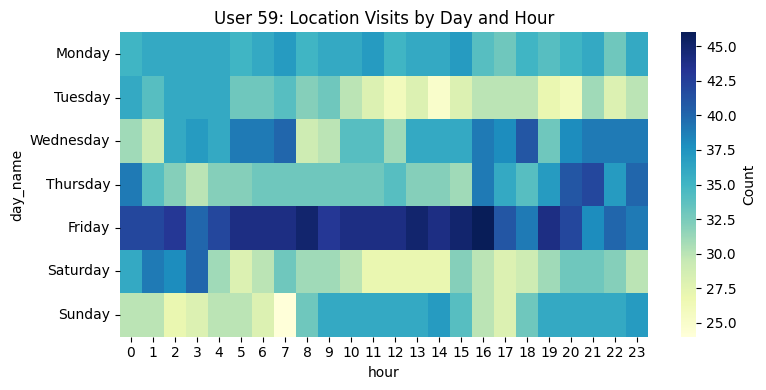


Analyzing temporal patterns for user 12...


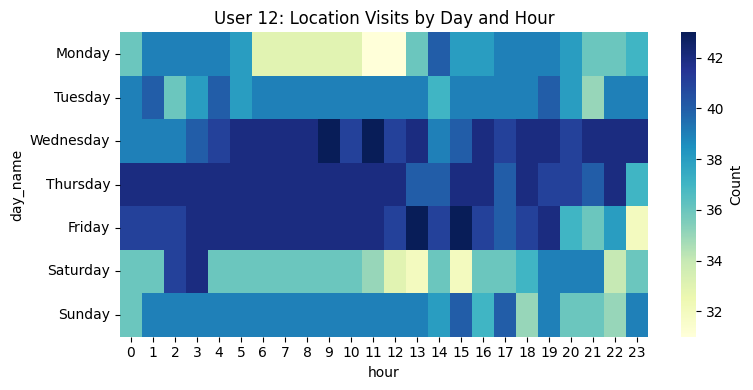

In [5]:
def analyze_temporal_patterns(user_id, df, significant_clusters, save_individual_plots=False):
    """
    Analyze temporal patterns of location visits by hour of day and day of week
    
    Parameters:
    - user_id: User identifier
    - df: DataFrame with GPS data
    - significant_clusters: DataFrame with significant locations
    - save_individual_plots: Whether to save individual plots for each cluster (default: False)
    """
    # Create necessary directories if they don't exist
    if not os.path.exists("graphs"):
        os.makedirs("graphs")
    if not os.path.exists("graphs/temporal"):
        os.makedirs("graphs/temporal")
    
    # Make sure datetime column is present
    if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(df['time'], unit='s')
    
    # Extract hour and day of week
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    # Map day of week numbers to names
    day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['day_name'] = df['day_of_week'].map(day_map)
    
    # Create a plot for each significant cluster only if requested
    if save_individual_plots:
        if not os.path.exists("graphs/temporal/clusters"):
            os.makedirs("graphs/temporal/clusters")
            
        for _, cluster in significant_clusters.iterrows():
            cluster_id = cluster['cluster']
            cluster_points = df[df['cluster'] == cluster_id]
            
            if len(cluster_points) == 0:
                continue
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Hour distribution
            sns.countplot(x='hour', data=cluster_points, ax=ax1)
            ax1.set_title(f'Hourly Distribution for Cluster {cluster_id}')
            ax1.set_xlabel('Hour of Day')
            ax1.set_ylabel('Count')
            
            # Day of week distribution
            sns.countplot(x='day_name', data=cluster_points, 
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                         ax=ax2)
            ax2.set_title(f'Day of Week Distribution for Cluster {cluster_id}')
            ax2.set_xlabel('Day of Week')
            ax2.set_ylabel('Count')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.savefig(f"graphs/temporal/clusters/user_{user_id}_cluster_{cluster_id}_temporal.png", dpi=300)
            plt.close()
    
    # Create an overall heatmap of location visits by hour and day (this is always saved)
    plt.figure(figsize=(8, 4))  # Much smaller size for the heatmap
    pivot = pd.crosstab(index=df['day_name'], columns=df['hour'])
    pivot = pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Count'})
    plt.title(f'User {user_id}: Location Visits by Day and Hour')
    plt.tight_layout()
    
    # Save the heatmap to graphs/temporal directory
    heatmap_file = f"graphs/temporal/user_{user_id}_temporal_heatmap.png"
    plt.savefig(heatmap_file, dpi=300)
    
    # Display the heatmap directly with a more appropriate size
    plt.show()
    
    # Clean up
    plt.close()

# Apply temporal analysis to our best users
for user_id in significant_locations:
    if len(significant_locations[user_id]) > 0:
        print(f"\nAnalyzing temporal patterns for user {user_id}...")
        # Set save_individual_plots to False to avoid saving individual cluster plots
        analyze_temporal_patterns(user_id, full_data[user_id], significant_locations[user_id], save_individual_plots=False)

### Integrating with Google Places API

In [ ]:
import requests
import time

# Replace with your actual API key
GOOGLE_PLACES_API_KEY = "YOUR_API_KEY_HERE"

def get_place_details(lat, lng, api_key=GOOGLE_PLACES_API_KEY):
    """
    Query Google Places API for details about a location
    """
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    params = {
        "location": f"{lat},{lng}",
        "radius": 50,  # Search radius in meters
        "key": api_key
    }
    
    try:
        response = requests.get(base_url, params=params)
        result = response.json()
        
        if result['status'] == 'OK' and len(result['results']) > 0:
            places = []
            for place in result['results'][:3]:  # Take top 3 results
                place_info = {
                    'name': place.get('name', 'Unknown'),
                    'types': place.get('types', []),
                    'vicinity': place.get('vicinity', ''),
                    'rating': place.get('rating', 0),
                }
                places.append(place_info)
            return places
        else:
            print(f"No places found near {lat}, {lng} or API error: {result['status']}")
            return []
            
    except Exception as e:
        print(f"Error querying Places API: {e}")
        return []

def classify_location_type(place_types, time_features):
    """
    Classify the type of location based on Places API types and temporal features
    
    Args:
        place_types: List of place types from Google Places API
        time_features: Dict containing temporal information about visits
    
    Returns:
        String representing the classified location type
    """
    # Flatten types from multiple places
    all_types = []
    for place in place_types:
        all_types.extend(place.get('types', []))
    
    # Count occurrences of each type
    type_counts = Counter(all_types)
    
    # Check for specific location types
    if any(t in type_counts for t in ['home', 'lodging', 'residential']):
        return 'Home'
    
    if any(t in type_counts for t in ['university', 'school', 'library', 'classroom']):
        return 'School/University'
    
    if any(t in type_counts for t in ['office', 'workplace', 'business', 'corporate']):
        return 'Workplace'
    
    if any(t in type_counts for t in ['restaurant', 'cafe', 'food', 'bar', 'bakery']):
        return 'Restaurant/Cafe'
    
    if any(t in type_counts for t in ['store', 'shop', 'shopping_mall', 'supermarket', 'grocery']):
        return 'Shopping'
    
    if any(t in type_counts for t in ['gym', 'fitness', 'stadium', 'sports', 'recreation']):
        return 'Recreation/Sports'
    
    if any(t in type_counts for t in ['park', 'natural_feature', 'campground']):
        return 'Outdoor/Park'
    
    if any(t in type_counts for t in ['bus_station', 'train_station', 'transit_station', 'subway_station']):
        return 'Transportation'
    
    # If no specific type matches, use temporal features for classification
    hour_dist = time_features.get('hour_distribution', {})
    day_dist = time_features.get('day_distribution', {})
    duration = time_features.get('avg_duration', 0)
    
    # Home: Often visited in evenings and mornings, weekends
    evening_visits = sum(hour_dist.get(h, 0) for h in range(18, 24))
    morning_visits = sum(hour_dist.get(h, 0) for h in range(5, 9))
    weekend_visits = day_dist.get('Saturday', 0) + day_dist.get('Sunday', 0)
    
    if evening_visits > 0.3 * sum(hour_dist.values()) and weekend_visits > 0.25 * sum(day_dist.values()):
        return 'Likely Home'
    
    # Work/School: Weekday daytime
    weekday_daytime = sum(day_dist.get(d, 0) for d in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    daytime_visits = sum(hour_dist.get(h, 0) for h in range(9, 17))
    
    if weekday_daytime > 0.7 * sum(day_dist.values()) and daytime_visits > 0.6 * sum(hour_dist.values()):
        return 'Likely Work/School'
    
    # Social venue: Evening and weekend visits
    if evening_visits > 0.5 * sum(hour_dist.values()) and weekend_visits > 0.4 * sum(day_dist.values()):
        return 'Likely Social Venue'
    
    # Short stays: Shopping or errands
    if duration < 30:  # Less than 30 minutes
        return 'Brief Stop/Errand'
        
    return 'Unknown'

def label_significant_locations(user_id, significant_clusters, full_data):
    """
    Label significant locations using the Google Places API
    """
    if len(significant_clusters) == 0:
        print(f"No significant locations to label for user {user_id}")
        return significant_clusters
    
    labeled_clusters = significant_clusters.copy()
    labeled_clusters['place_info'] = None
    labeled_clusters['location_type'] = None
    
    for idx, cluster in labeled_clusters.iterrows():
        # Get temporal features for this cluster
        cluster_points = full_data[full_data['cluster'] == cluster['cluster']]
        
        # Skip if no points in cluster (shouldn't happen)
        if len(cluster_points) == 0:
            continue
            
        # Extract hour and day of week if not already present
        if 'hour' not in cluster_points.columns:
            cluster_points['datetime'] = pd.to_datetime(cluster_points['time'], unit='s')
            cluster_points['hour'] = cluster_points['datetime'].dt.hour
            cluster_points['day_of_week'] = cluster_points['datetime'].dt.dayofweek
            day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                      4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
            cluster_points['day_name'] = cluster_points['day_of_week'].map(day_map)
        
        # Compile temporal features
        hour_counts = cluster_points['hour'].value_counts().to_dict()
        day_counts = cluster_points['day_name'].value_counts().to_dict()
        
        temporal_features = {
            'hour_distribution': hour_counts,
            'day_distribution': day_counts,
            'avg_duration': cluster['avg_duration'] if 'avg_duration' in cluster else 0,
            'visits_per_day': cluster['visits_per_day'] if 'visits_per_day' in cluster else 0
        }
        
        # Query Google Places API
        print(f"Querying Places API for cluster {cluster['cluster']}...")
        place_info = get_place_details(cluster['center_lat'], cluster['center_lon'])
        
        # Add a delay to respect API rate limits
        time.sleep(0.5)
        
        # Store the place information
        labeled_clusters.at[idx, 'place_info'] = place_info
        
        # Classify the location type
        location_type = classify_location_type(place_info, temporal_features)
        labeled_clusters.at[idx, 'location_type'] = location_type
        
        print(f"Cluster {cluster['cluster']} classified as: {location_type}")
    
    return labeled_clusters

# NOTE: We'll run this with a conditional to avoid accidentally using up API quota
use_places_api = False  # Set to True when ready to use the API

if use_places_api:
    for user_id in significant_locations:
        print(f"\nLabeling significant locations for user {user_id}...")
        significant_locations[user_id] = label_significant_locations(
            user_id, significant_locations[user_id], full_data[user_id]
        )
else:
    print("\nSkipping Google Places API integration (set use_places_api = True to enable)")



Labeling significant locations for user 59...
Querying Places API for cluster 0...
No places found near 43.704942722064345, -72.29045998300074 or API error: REQUEST_DENIED
Cluster 0 classified as: Brief Stop/Errand
Querying Places API for cluster 1...
No places found near 43.70172489714286, -72.29168269428571 or API error: REQUEST_DENIED
Cluster 1 classified as: Unknown
Querying Places API for cluster 2...
No places found near 43.70278866666666, -72.28409366666666 or API error: REQUEST_DENIED
Cluster 2 classified as: Unknown
Querying Places API for cluster 3...
No places found near 43.708913715291764, -72.28409665049294 or API error: REQUEST_DENIED
Cluster 3 classified as: Likely Work/School
Querying Places API for cluster 4...
No places found near 43.7032106832625, -72.2877067910875 or API error: REQUEST_DENIED
Cluster 4 classified as: Likely Work/School
Querying Places API for cluster 5...
No places found near 43.70395913787531, -72.28722431744322 or API error: REQUEST_DENIED
Cluste

### Evaluating Classification Accuracy

In [7]:
def evaluate_classification_accuracy(labeled_clusters):
    """
    Manually evaluate the accuracy of our classification based on place info
    and temporal patterns. In a real implementation, you would compare with ground truth.
    """
    # Create directories if they don't exist
    if not os.path.exists("graphs"):
        os.makedirs("graphs")
    if not os.path.exists("graphs/evaluation"):
        os.makedirs("graphs/evaluation")
    
    # Without ground truth, we'll use a heuristic approach to estimate accuracy
    # based on confidence in the classification
    
    confidence_levels = []
    
    for _, cluster in labeled_clusters.iterrows():
        location_type = cluster['location_type']
        place_info = cluster['place_info']
        
        # Skip if location_type is None (shouldn't happen if we've labeled everything)
        if location_type is None or place_info is None:
            confidence_levels.append(0)
            continue
        
        # Initialize confidence score
        confidence = 0.5  # Starting confidence
        
        # Check if the classified type appears explicitly in the place types
        type_keywords = {
            'Home': ['home', 'lodging', 'residential'],
            'School/University': ['university', 'school', 'library', 'classroom'],
            'Workplace': ['office', 'workplace', 'business', 'corporate'],
            'Restaurant/Cafe': ['restaurant', 'cafe', 'food', 'bar', 'bakery'],
            'Shopping': ['store', 'shop', 'shopping_mall', 'supermarket', 'grocery'],
            'Recreation/Sports': ['gym', 'fitness', 'stadium', 'sports', 'recreation'],
            'Outdoor/Park': ['park', 'natural_feature', 'campground'],
            'Transportation': ['bus_station', 'train_station', 'transit_station', 'subway_station']
        }
        
        # Get keywords for this location type
        relevant_keywords = type_keywords.get(location_type.split('/')[0], [])
        
        # Check if any place has matching types
        matched_types = False
        for place in place_info:
            types = place.get('types', [])
            if any(keyword in type for type in types for keyword in relevant_keywords):
                confidence += 0.3
                matched_types = True
                break
        
        # If "Likely" prefix, it's based on temporal patterns, so less confident
        if location_type.startswith('Likely'):
            if not matched_types:  # If no type match, we're relying on temporal patterns
                confidence -= 0.1
        
        # If we have a clear type from Places API, high confidence
        if matched_types:
            confidence = min(confidence, 0.9)  # Cap at 0.9
        
        # Store the confidence level
        confidence_levels.append(confidence)
    
    # Calculate overall estimated accuracy
    if confidence_levels:
        mean_confidence = sum(confidence_levels) / len(confidence_levels)
        print(f"Estimated classification accuracy: {mean_confidence:.2f} (or {mean_confidence*100:.1f}%)")
        
        # Distribution of confidence levels
        confidence_bins = pd.cut(confidence_levels, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        confidence_counts = pd.Series(confidence_bins).value_counts().sort_index()
        
        plt.figure(figsize=(10, 6))
        confidence_counts.plot(kind='bar', color='skyblue')
        plt.title('Distribution of Classification Confidence Levels')
        plt.xlabel('Confidence Level')
        plt.ylabel('Number of Locations')
        
        # Save to graphs/evaluation directory
        plt.savefig("graphs/evaluation/classification_confidence.png", dpi=300)
        plt.close()
        
        return {
            'mean_confidence': mean_confidence,
            'confidence_distribution': confidence_counts
        }
    else:
        print("No confidence levels available to evaluate")
        return None

# If we've labeled our locations, evaluate the classification
if use_places_api:
    for user_id in significant_locations:
        print(f"\nEvaluating classification accuracy for user {user_id}...")
        evaluation = evaluate_classification_accuracy(significant_locations[user_id])


Evaluating classification accuracy for user 59...
Estimated classification accuracy: 0.47 (or 47.2%)

Evaluating classification accuracy for user 12...
Estimated classification accuracy: 0.47 (or 47.1%)


### Final Visualization and Reporting


Creating final report for user 59...
Labeled interactive map saved as graphs/reports/user_59_labeled_locations.html


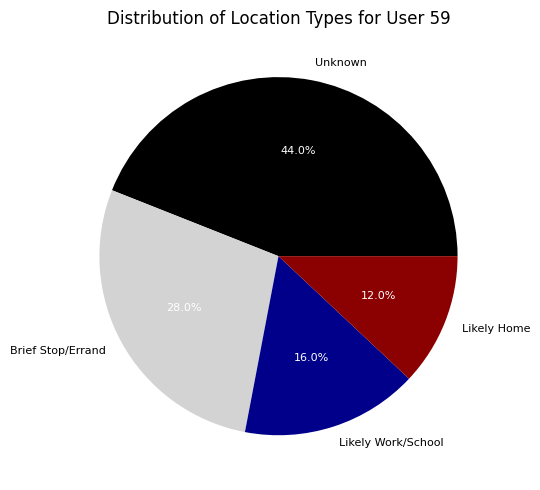


Summary of Significant Locations for User 59:
    cluster  center_lat  center_lon  duration_minutes  point_count  \
0         0   43.704943  -72.290460      94429.466667         4283   
1         1   43.701725  -72.291683      93866.933333           70   
2         2   43.702789  -72.284094       8039.766667            6   
3         3   43.708914  -72.284097      90792.350000           85   
4         4   43.703211  -72.287707      70531.316667            8   
5         5   43.703959  -72.287224      90890.666667          243   
6         6   43.703342  -72.285202      89058.683333           16   
7         7   43.702453  -72.288021      90378.050000            8   
8         8   43.706644  -72.287085      88403.716667          395   
9         9   43.707580  -72.288992      60848.516667           44   
10       10   43.651709  -72.309818        639.950000           24   
11       11   43.700944  -72.289403      67708.766667           17   
12       12   43.705334  -72.278227       7

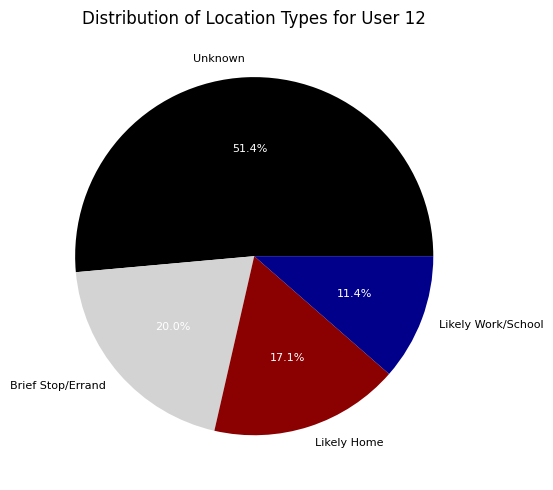


Summary of Significant Locations for User 12:
    cluster  center_lat  center_lon  duration_minutes  point_count  \
0         0   43.637521  -72.248388      95020.066667         4724   
1         1   43.703881  -72.282392      69106.433333            7   
2         2   43.708710  -72.285540      90879.566667           48   
3         3   43.708930  -72.284084      90969.600000          138   
4         4   43.706970  -72.286811      90569.600000          291   
5         5   43.705809  -72.288954      93547.950000          546   
6         6   43.637041  -72.252927      93392.716667            6   
7         7   43.652007  -72.252727      93020.066667           71   
8         8   43.677304  -72.260295       7920.050000            6   
9         9   43.646294  -72.254095      92534.200000           33   
10       10   43.702859  -72.290562      87249.583333           82   
11       11   43.705023  -72.294866      82299.366667           40   
12       12   43.638277  -72.269837      76

In [8]:
def create_final_report(user_id, labeled_clusters, full_data):
    """
    Create a comprehensive report of our analysis
    """
    # Create necessary directories if they don't exist
    if not os.path.exists("graphs"):
        os.makedirs("graphs")
    if not os.path.exists("graphs/reports"):
        os.makedirs("graphs/reports")
    
    if labeled_clusters is None or len(labeled_clusters) == 0:
        print(f"No labeled clusters available for user {user_id}")
        return
    
    # Create a map with labeled locations (full size for saved file)
    center_lat = full_data['latitude'].mean()
    center_lon = full_data['longitude'].mean()
    
    # Create a map without size constraints for saving
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
    
    # Color mapping for different location types
    color_map = {
        'Home': 'red',
        'Likely Home': 'darkred',
        'School/University': 'blue',
        'Workplace': 'purple',
        'Likely Work/School': 'darkblue',
        'Restaurant/Cafe': 'orange',
        'Shopping': 'green',
        'Recreation/Sports': 'lightgreen',
        'Outdoor/Park': 'darkgreen',
        'Transportation': 'gray',
        'Likely Social Venue': 'cadetblue',
        'Brief Stop/Errand': 'lightgray',
        'Unknown': 'black'
    }
    
    # Check if location_type exists in the DataFrame
    has_location_types = 'location_type' in labeled_clusters.columns
    
    # Add markers for significant locations
    for _, cluster in labeled_clusters.iterrows():
        # Get location type if available, otherwise use 'Unknown'
        if has_location_types:
            location_type = cluster['location_type']
            if location_type is None:
                location_type = 'Unknown'
        else:
            location_type = 'Unknown'  # No location types available
        
        color = color_map.get(location_type, 'black')
        
        # Create popup text with cluster details
        popup_text = f"""
        <b>Cluster:</b> {cluster['cluster']}<br>
        <b>Duration:</b> {cluster['duration_minutes']:.1f} minutes<br>
        <b>Visit days:</b> {cluster['visit_days']}<br>
        """
        
        # Add location type if available
        if has_location_types:
            popup_text = f"<b>Type:</b> {location_type}<br>" + popup_text
        
        # Add place information if available
        if has_location_types and 'place_info' in cluster and cluster['place_info']:
            place_info = cluster['place_info']
            popup_text += "<b>Nearby Places:</b><br>"
            for place in place_info:
                popup_text += f"- {place.get('name', 'Unknown')}: {', '.join(place.get('types', [])[:3])}<br>"
        
        folium.CircleMarker(
            location=[cluster['center_lat'], cluster['center_lon']],
            radius=10,
            popup=folium.Popup(popup_text, max_width=300),
            fill=True,
            fill_color=color,
            color=color,
            fill_opacity=0.7
        ).add_to(m)
    
    # Add a legend if we have location types
    if has_location_types:
        legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; right: 50px; 
                         border:2px solid grey; z-index:9999; 
                         background-color:white;
                         padding: 10px;
                         font-size:14px;
                         ">
             <b>Location Types</b><br>
        '''
        
        # Add each location type to the legend
        for location_type, color in color_map.items():
            legend_html += f'<i class="fa fa-circle" style="color:{color}"></i> {location_type}<br>'
        
        legend_html += '</div>'
        
        m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save the map (full size) to graphs/reports directory
    map_file = f"graphs/reports/user_{user_id}_labeled_locations.html"
    m.save(map_file)
    print(f"Labeled interactive map saved as {map_file}")
    
    # Display the map in the notebook with controlled size
    from IPython.display import HTML, display
    display(HTML(f'<div style="width:600px; height:400px">{m._repr_html_()}</div>'))
    
    # Create pie chart of location types if available
    if has_location_types and not labeled_clusters['location_type'].isna().all():
        type_counts = labeled_clusters['location_type'].value_counts()
        
        plt.figure(figsize=(6, 5))  # Small standard size for the pie chart
        wedges, texts, autotexts = plt.pie(
            type_counts, 
            labels=type_counts.index, 
            autopct='%1.1f%%',
            textprops={'fontsize': 9},
            colors=[color_map.get(t, 'gray') for t in type_counts.index]
        )
        
        # Adjust text properties for better readability
        for text in texts:
            text.set_fontsize(8)
        
        for autotext in autotexts:
            autotext.set_fontsize(8)
            autotext.set_color('white')
        
        plt.title(f'Distribution of Location Types for User {user_id}')
        plt.tight_layout()
        
        # Save to graphs/reports directory
        pie_chart_file = f"graphs/reports/user_{user_id}_location_types.png"
        plt.savefig(pie_chart_file, dpi=300)
        plt.show()
        plt.close()
    
    # Create summary table
    summary = labeled_clusters.copy()
    if has_location_types:
        summary = summary[['cluster', 'center_lat', 'center_lon', 'duration_minutes', 
                          'point_count', 'visit_days', 'location_type']]
    else:
        summary = summary[['cluster', 'center_lat', 'center_lon', 'duration_minutes', 
                          'point_count', 'visit_days']]
    
    # Display the summary table in output
    print(f"\nSummary of Significant Locations for User {user_id}:")
    print(summary)
    
    # Convert to HTML table
    html_table = summary.to_html(index=False)
    
    # Create a simple HTML report
    html_report = f"""
    <html>
    <head>
        <title>Location Analysis Report - User {user_id}</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            h1, h2 {{ color: #333366; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }}
            th {{ background-color: #f2f2f2; }}
            tr:hover {{ background-color: #f5f5f5; }}
            .chart {{ margin-top: 20px; text-align: center; }}
            img {{ max-width: 100%; }}
        </style>
    </head>
    <body>
        <h1>Location Analysis Report - User {user_id}</h1>
        
        <h2>Summary of Significant Locations</h2>
        {html_table}
    """
    
    # Add pie chart section if location types are available
    if has_location_types:
        pie_chart_file = f"graphs/reports/user_{user_id}_location_types.png"
        html_report += f"""
        <div class="chart">
            <h2>Distribution of Location Types</h2>
            <img src="../{pie_chart_file}" alt="Location Types Distribution">
        </div>
        """
    
    # Continue with the rest of the report
    html_report += f"""
        <div class="chart">
            <h2>Spatial Distribution of Locations</h2>
            <p>View the interactive map: <a href="{map_file}" target="_blank">Open Map</a></p>
        </div>
        
        <h2>Methodology</h2>
        <p>
            This analysis used DBSCAN clustering to identify significant locations based on GPS data.
            {' Locations were classified using temporal patterns of visits.' if has_location_types else ''}
            A location was considered significant if the user spent at least 10 minutes there on multiple occasions.
        </p>
    </body>
    </html>
    """
    
    # Save the HTML report to graphs/reports directory
    report_file = f"graphs/reports/user_{user_id}_report.html"
    with open(report_file, "w") as f:
        f.write(html_report)
    
    print(f"Report saved as {report_file}")

# Create final reports for our users
for user_id in significant_locations:
    print(f"\nCreating final report for user {user_id}...")
    create_final_report(user_id, significant_locations[user_id], full_data[user_id])

print("\nProject analysis complete!")